On a side note, Instead of adding multiple files for the atlas, we've integrated the EM Optimization step we've merged the integration layer and the final atlas-based probability computation into one final layer at the end, and used the whole thing as one single model.

We also had to make use of changing learning rates, and add early stopping for optimal training.

You can see that we used Lungs Images for segmentation instead of Brains (as done in the original paper!)

In [ ]:
import os
import numpy as np
import pandas as pd
import math
import cv2
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
os.listdir()
os.chdir('drive/MyDrive/2DMasks')
plt.rcParams['figure.figsize'] = [16, 8]
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Conv2D,BatchNormalization,MaxPool2D,Concatenate,Add,Dropout,ReLU,Conv2DTranspose,UpSampling2D

In [ ]:
image_path = '2d_images'
mask_path = '2d_masks'

In [ ]:
autotune = tf.data.experimental.AUTOTUNE
image_size = 448
batch_size = 16

In [ ]:
exclude = [image_path+'/ID_0254_Z_0075.tif',mask_path+'/ID_0254_Z_0075.tif',
           image_path+'/ID_0052_Z_0108.tif',mask_path+'/ID_0052_Z_0108.tif',
           image_path+'/ID_0079_Z_0072.tif',mask_path+'/ID_0079_Z_0072.tif',
           image_path+'/ID_0134_Z_0137.tif',mask_path+'/ID_0134_Z_0137.tif']

num_files = len(os.listdir(image_path))-len(exclude)/2
print(num_files)

def read_image(image):
    path = image.numpy().decode('utf-8')
    if path not in exclude:
        image = cv2.imread(path,0)
        image = np.expand_dims(image,2)
        image = tf.image.resize(image, [image_size,image_size])
    else:
        image = np.zeros((image_size,image_size,1),dtype=np.float32)
    return image

def read_mask(image):
    path = image.numpy().decode('utf-8')
    if path not in exclude:
        image = cv2.imread(path,0)
        image = image*257.
        image = np.expand_dims(image,2)
        image = tf.image.resize(image, [image_size,image_size])
    else:
        image = np.zeros((image_size,image_size,1),dtype=np.float32)
    return image

def aug(image,label):
    seed = np.random.randint(0,64)
    image = tf.image.random_flip_left_right(image, seed=seed)
    image = tf.image.random_flip_up_down(image, seed=seed)
    image = tf.image.random_contrast(image, 0.3, 0.7, seed=seed)
    label = tf.image.random_flip_left_right(label, seed=seed)
    label = tf.image.random_flip_up_down(label, seed=seed)
    label = tf.image.random_contrast(label, 0.3, 0.7, seed=seed)
    return image,label

dataset_image = tf.data.Dataset.list_files('2d_images/*.tif',shuffle=False,seed=None).map(lambda x: tf.py_function(read_image,[x],[tf.float32]),num_parallel_calls=autotune,deterministic=False)
dataset_mask = tf.data.Dataset.list_files('2d_masks/*.tif',shuffle=False,seed=None).map(lambda x: tf.py_function(read_mask,[x],[tf.float32]),num_parallel_calls=autotune,deterministic=False)

dataset = tf.data.Dataset.zip((dataset_image, dataset_mask))
dataset = dataset.repeat().shuffle(128).batch(batch_size).cache().prefetch(autotune)
train = dataset.take(int(0.8*num_files//batch_size))
test = dataset.skip(int(0.8*num_files//batch_size))

263.0


In [ ]:
keep_scale = 0.2
l1l2 = tf.keras.regularizers.l1_l2(l1=0, l2=0.0005)

def resblock(x,level='en_l1',filters=64,keep_scale=keep_scale,l1l2=l1l2,downsample=False,bn_act=True,first_layer=False):
    if downsample:
        if not first_layer:
            x_H = Conv2D(filters,(3,3),(2,2),padding='same',kernel_regularizer=l1l2,name=level+'_Hconv')(x)
            x = Conv2D(filters/2,(3,3),padding='same',kernel_regularizer=l1l2,name=level+'_conv1')(x)
        else:
            x_H = Conv2D(filters,(3,3),(2,2),padding='same',kernel_regularizer=l1l2,name=level+'_Hconv')(x)
            x = Conv2D(filters,(3,3),padding='same',kernel_regularizer=l1l2,name=level+'_conv1')(x)
    else:
        x_H = x
        x = Conv2D(filters,(3,3),padding='same',kernel_regularizer=l1l2,name=level+'_conv1')(x)
    x = BatchNormalization(name=level+'_conv1bn')(x)
    x = ReLU(name=level+'_conv1relu')(x)
    if downsample:
        x = Conv2D(filters,(3,3),(2,2),padding='same',kernel_regularizer=l1l2,name=level+'_conv2')(x)
    else:
        x = Conv2D(filters,(3,3),padding='same',kernel_regularizer=l1l2,name=level+'_conv2')(x)
    x = BatchNormalization(name=level+'_conv2bn')(x)
    x = ReLU(name=level+'_conv2relu')(x)
    x = Add(name=level+'_add')([x_H*keep_scale,x*(1-keep_scale)])
    if bn_act:
        x = BatchNormalization(name=level+'_finalbn')(x)
        x = ReLU(name=level+'_finalrelu')(x)
    return x

In [ ]:
inputs = tf.keras.Input(shape=(image_size,image_size,1),name='input')

layer_0 = Conv2D(64,(7,7),strides=(2,2),padding='same',name='input_conv1',activation=None)(inputs)
layer = BatchNormalization(name='input_conv1bn')(layer_0)
layer = ReLU(name='input_conv1relu')(layer)

## Encoder
layer = resblock(layer,'en_l1',64,keep_scale,l1l2,downsample=True,bn_act=True,first_layer=True)
layer = resblock(layer,'en_l2',64,keep_scale,l1l2,downsample=False,bn_act=True)
encoder_1 = resblock(layer,'en_l3',64,keep_scale,l1l2,downsample=False,bn_act=False)
layer = BatchNormalization(name='en_l3_finalbn')(encoder_1)
layer = ReLU(name='en_l3_finalrelu')(layer)

layer = resblock(layer,'en_l4',128,keep_scale,l1l2,downsample=True,bn_act=True)
layer = resblock(layer,'en_l5',128,keep_scale,l1l2,downsample=False,bn_act=True)
layer = resblock(layer,'en_l6',128,keep_scale,l1l2,downsample=False,bn_act=True)
encoder_2 = resblock(layer,'en_l7',128,keep_scale,l1l2,downsample=False,bn_act=False)
layer = BatchNormalization(name='en_l7_finalbn')(encoder_2)
layer = ReLU(name='en_l7_finalrelu')(layer)

layer = resblock(layer,'en_l8',256,keep_scale,l1l2,downsample=True,bn_act=True)
layer = resblock(layer,'en_l9',256,keep_scale,l1l2,downsample=False,bn_act=True)
layer = resblock(layer,'en_l10',256,keep_scale,l1l2,downsample=False,bn_act=True)
layer = resblock(layer,'en_l11',256,keep_scale,l1l2,downsample=False,bn_act=True)
layer = resblock(layer,'en_l12',256,keep_scale,l1l2,downsample=False,bn_act=True)
encoder_3 = resblock(layer,'en_l13',256,keep_scale,l1l2,downsample=False,bn_act=False)
layer = BatchNormalization(name='en_l13_finalbn')(encoder_3)
layer = ReLU(name='en_l13_finalrelu')(layer)

layer = resblock(layer,'en_l14',512,keep_scale,l1l2,downsample=True,bn_act=True)
layer = resblock(layer,'en_l15',512,keep_scale,l1l2,downsample=False,bn_act=True)
layer = resblock(layer,'en_l16',512,keep_scale,l1l2,downsample=False,bn_act=True)

## DAC block
b1 = Conv2D(512,(3,3),padding='same',dilation_rate=1,name='dac_b1_conv1',activation=None)(layer)
# b1 = BatchNormalization()(b1)
# b1 = ReLU(name='dac_b1_relu')(b1)

b2 = Conv2D(512,(3,3),padding='same',dilation_rate=3,name='dac_b2_conv1',activation=None)(layer)
b2 = Conv2D(512,(1,1),padding='same',dilation_rate=1,name='dac_b2_conv2',activation=None)(b2)
# b2 = BatchNormalization()(b2)
# b2 = ReLU(name='dac_b2_relu')(b2)

b3 = Conv2D(512,(3,3),padding='same',dilation_rate=1,name='dac_b3_conv1',activation=None)(layer)
b3 = Conv2D(512,(3,3),padding='same',dilation_rate=3,name='dac_b3_conv2',activation=None)(b3)
b3 = Conv2D(512,(1,1),padding='same',dilation_rate=1,name='dac_b3_conv3',activation=None)(b3)
# b3 = BatchNormalization()(b3)
# b3 = ReLU(name='dac_b3_relu')(b3)

b4 = Conv2D(512,(3,3),padding='same',dilation_rate=1,name='dac_b4_conv1',activation=None)(layer)
b4 = Conv2D(512,(3,3),padding='same',dilation_rate=3,name='dac_b4_conv2',activation=None)(b4)
b4 = Conv2D(512,(3,3),padding='same',dilation_rate=5,name='dac_b4_conv3',activation=None)(b4)
b4 = Conv2D(512,(1,1),padding='same',dilation_rate=1,name='dac_b4_conv4',activation=None)(b4)
# b4 = BatchNormalization()(b4)
# b4 = ReLU(name='dac_b4_relu')(b4)

layer = Add(name='dac_add')([layer,b1,b2,b3,b4])
# layer = BatchNormalization(name='dac_bn')(layer)
layer = ReLU(name='dac_relu')(layer)

## RMP block
b1 = MaxPool2D((2,2),strides=(2,2),padding='valid',name='rmp_b1_pool')(layer)
b1 = Conv2D(1,(1,1),padding='valid',name='rmb_b1_conv1',activation=None)(b1)
b1 = Conv2DTranspose(1,(1,1),(2,2),padding='valid',kernel_regularizer=l1l2,output_padding=0,activation=None)(b1)
b1 = tf.image.resize(b1, [14,14], method=tf.image.ResizeMethod.BILINEAR)

b2 = MaxPool2D((3,3),strides=(3,3),padding='valid',name='rmp_b2_pool')(layer)
b2 = Conv2D(1,(1,1),padding='valid',name='rmb_b2_conv1',activation=None)(b2)
b2 = Conv2DTranspose(1,(1,1),(3,3),padding='valid',kernel_regularizer=l1l2,output_padding=0,activation=None)(b2)
b2 = tf.image.resize(b2, [14,14], method=tf.image.ResizeMethod.BILINEAR)

b3 = MaxPool2D((5,5),strides=(5,5),padding='valid',name='rmp_b3_pool')(layer)
b3 = Conv2D(1,(1,1),padding='valid',name='rmb_b3_conv1',activation=None)(b3)
b3 = Conv2DTranspose(1,(1,1),(5,5),padding='valid',kernel_regularizer=l1l2,output_padding=0,activation=None)(b3)
b3 = tf.image.resize(b3, [14,14], method=tf.image.ResizeMethod.BILINEAR)

b4 = MaxPool2D((6,6),strides=(6,6),padding='valid',name='rmp_b4_pool')(layer)
b4 = Conv2D(1,(1,1),padding='valid',name='rmb_b4_conv1',activation=None)(b4)
b4 = Conv2DTranspose(1,(1,1),(6,6),padding='valid',kernel_regularizer=l1l2,output_padding=0,activation=None)(b4)
b4 = tf.image.resize(b4, [14,14], method=tf.image.ResizeMethod.BILINEAR)

layer = Concatenate(name='rmp_concat')([layer,b1,b2,b3,b4])
layer = ReLU(name='rmp_relu')(layer)

layer = Conv2D(256,(1,1),padding='same',kernel_regularizer=l1l2,name='de_l1_conv1',activation=None)(layer)
layer = BatchNormalization(name='de_l1_conv1bn')(layer)
layer = ReLU(name='de_l1_conv1relu')(layer)
layer = Conv2DTranspose(256,(3,3),(2,2),padding='same',kernel_regularizer=l1l2,output_padding=1,name='de_l1_deconv2',activation=None)(layer)
layer = BatchNormalization(name='de_l1_conv2bn')(layer)
layer = ReLU(name='de_l1_deconv2relu')(layer)
layer = Conv2D(256,(3,3),padding='same',kernel_regularizer=l1l2,name='de_l1_conv3',activation=None)(layer)
layer = Add(name='de_l1_add')([encoder_3*keep_scale,layer*(1-keep_scale)])
layer = BatchNormalization(name='de_l1_conv3bn')(layer)
layer = ReLU(name='de_l1_conv3relu')(layer)

layer = Conv2D(128,(1,1),padding='same',kernel_regularizer=l1l2,name='de_l2_conv1',activation=None)(layer)
layer = BatchNormalization(name='de_l2_conv1bn')(layer)
layer = ReLU(name='de_l2_conv1relu')(layer)
layer = Conv2DTranspose(128,(3,3),(2,2),padding='same',kernel_regularizer=l1l2,output_padding=1,name='de_l2_deconv2',activation=None)(layer)
layer = BatchNormalization(name='de_l2_conv2bn')(layer)
layer = ReLU(name='de_l2_deconv2relu')(layer)
layer = Conv2D(128,(1,1),padding='same',kernel_regularizer=l1l2,name='de_l2_conv3',activation=None)(layer)
layer = Add(name='de_l2_add')([encoder_2*keep_scale,layer*(1-keep_scale)])
layer = BatchNormalization(name='de_l2_conv3bn')(layer)
layer = ReLU(name='de_l2_conv3relu')(layer)

layer = Conv2D(64,(1,1),padding='same',kernel_regularizer=l1l2,name='de_l3_conv1',activation=None)(layer)
layer = BatchNormalization(name='de_l3_conv1bn')(layer)
layer = ReLU(name='de_l3_conv1relu')(layer)
layer = Conv2DTranspose(64,(3,3),(2,2),padding='same',kernel_regularizer=l1l2,output_padding=1,name='de_l3_deconv2',activation=None)(layer)
layer = BatchNormalization(name='de_l3_conv2bn')(layer)
layer = ReLU(name='de_l3_deconv2relu')(layer)
layer = Conv2D(64,(1,1),padding='same',kernel_regularizer=l1l2,name='de_l3_conv3',activation=None)(layer)
layer = Add(name='de_l3_add')([encoder_1*keep_scale,layer*(1-keep_scale)])
layer = BatchNormalization(name='de_l3_conv3bn')(layer)
layer = ReLU(name='de_l3_conv3relu')(layer)

layer = Conv2D(64,(1,1),padding='same',kernel_regularizer=l1l2,name='de_l4_conv1',activation=None)(layer)
layer = BatchNormalization(name='de_l4_conv1bn')(layer)
layer = ReLU(name='de_l4_conv1relu')(layer)
layer = Conv2DTranspose(64,(3,3),(2,2),padding='same',kernel_regularizer=l1l2,output_padding=1,name='de_l4_deconv2',activation=None)(layer)
layer = BatchNormalization(name='de_l4_conv2bn')(layer)
layer = ReLU(name='de_l4_deconv2relu')(layer)
layer = Conv2D(64,(1,1),padding='same',kernel_regularizer=l1l2,name='de_l4_conv3',activation=None)(layer)
layer = Add(name='de_l4_add')([layer_0*keep_scale,layer*(1-keep_scale)])
layer = BatchNormalization(name='de_l4_conv3bn')(layer)
layer = ReLU(name='de_l4_conv3relu')(layer)

layer = Conv2DTranspose(32,(3,3),(2,2),padding='same',kernel_regularizer=l1l2,name='final_deconv1',activation=None)(layer)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)
layer = Conv2D(32,(3,3),padding='same',kernel_regularizer=l1l2,name='final_conv1',activation=None)(layer)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)
outputs = Conv2D(1,(3,3),padding='same',name='output',activation=None)(layer)

model = tf.keras.Model(inputs,outputs,name='CE-Net')
print(model.summary())

Model: "CE-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 448, 448, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_conv1 (Conv2D)           (None, 224, 224, 64  3200        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 input_conv1bn (BatchNormalizat  (None, 224, 224, 64  256        ['input_conv1[0][0]']            
 ion)                           )                                                            

In [ ]:
lr_init = 0.0001
total_epoch = 100

In [ ]:
def scheduler_1(epoch):
    epoch += 1

    if epoch <= 4:
        return lr_init

    if epoch >= 5 and epoch <= 10:
        return lr_init-lr_init*math.exp(0.25*(epoch-8))/40

    elif epoch >= 11 and epoch <= 50:
        return lr_init*math.exp(-0.05*(epoch-10))

    else:
        return scheduler_1(50-1)

In [ ]:
def scheduler_2(epoch):
    epoch += 1

    if epoch == 1:
        return lr_init

    elif epoch >= 2 and epoch <= 35:
        return (0.25*epoch**3)*math.exp(-0.25*epoch)*lr_init

    else:
        return scheduler_2(35-1)

In [ ]:
def scheduler_3(epoch):

    if epoch == 0:
        return lr_init

    else:
        return lr_init*((1-epoch/100)**0.9)

[0.0001, 9.909954834128343e-05, 9.819818665965754e-05, 9.729590473501306e-05, 9.63926921258551e-05, 9.548853816214998e-05, 9.458343193786322e-05, 9.367736230317176e-05, 9.277031785633283e-05, 9.186228693518995e-05, 9.095325760829622e-05, 9.004321766563289e-05, 8.91321546089e-05, 8.822005564135439e-05, 8.73069076571686e-05, 8.639269723028191e-05, 8.547741060271343e-05, 8.45610336723042e-05, 8.36435519798534e-05, 8.272495069561094e-05, 8.180521460508584e-05, 8.088432809412662e-05, 7.996227513322693e-05, 7.903903926100555e-05, 7.811460356680608e-05, 7.718895067235705e-05, 7.626206271242883e-05, 7.533392131441787e-05, 7.440450757678327e-05, 7.347380204625457e-05]


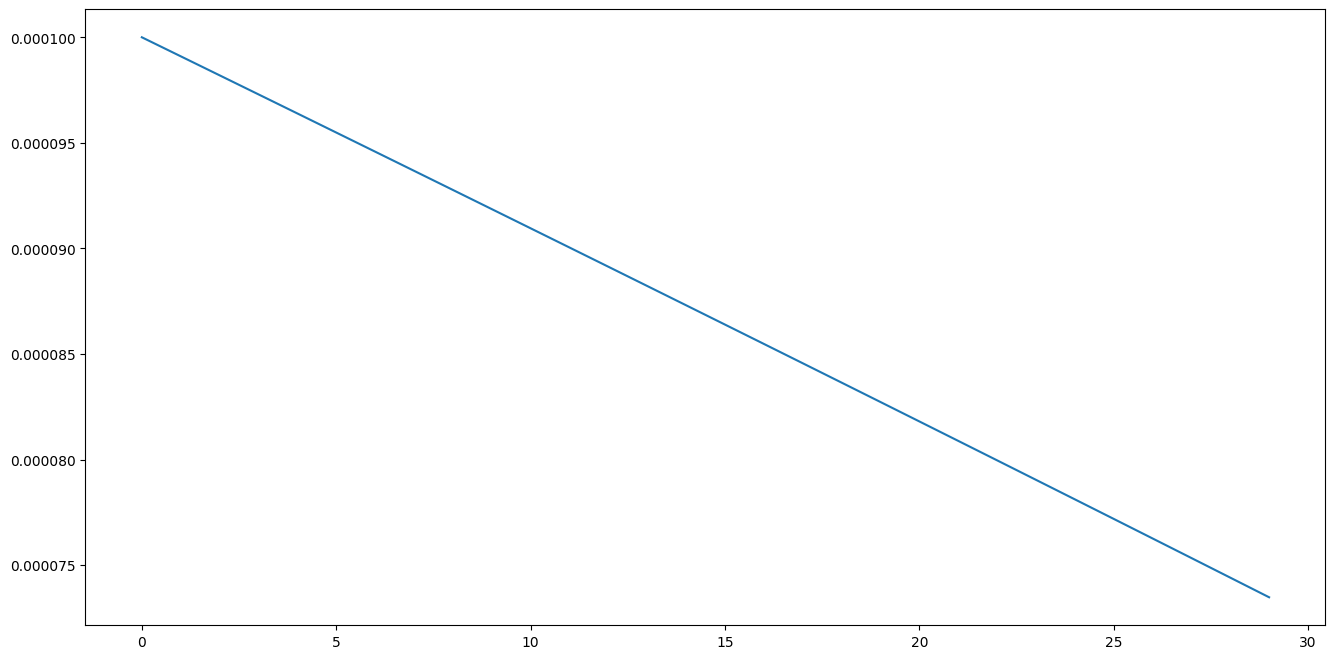

In [ ]:
stage = [i for i in range(0,30)]
lr_plot = [scheduler_3(x) for x in stage]
plt.plot(stage, lr_plot)
print(lr_plot)

In [ ]:
smooth = K.epsilon()
threshold = 0.8
label_smoothing = 0.0
bce_weight = 0.5

def dice_coeff(y_true, y_pred):
    numerator = tf.math.reduce_sum(y_true * y_pred) + smooth
    denominator = tf.math.reduce_sum(y_true) + tf.math.reduce_sum(y_pred) + smooth
    return tf.math.reduce_mean(2.* numerator / denominator) * 448 * 448

def dice_loss(y_true, y_pred):
    return - dice_coeff(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return bce_weight * tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=label_smoothing) - dice_coeff(y_true, y_pred)

def bce_dice_loss_try(y_true, y_pred):
    x = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=label_smoothing)
    y = -dice_coeff(y_true, y_pred)
    return x + x/(x+y)*y

def iou(y_true, y_pred):
    overlap = tf.math.logical_and((y_true > threshold),(y_pred > threshold))
    union = tf.math.logical_or((y_true > threshold),(y_pred > threshold))
    iou = (tf.cast(tf.math.count_nonzero(overlap),tf.float32) + smooth) / (tf.cast(tf.math.count_nonzero(union),tf.float32) + smooth)
    return iou

In [ ]:
loss = bce_dice_loss
optimizer = tf.keras.optimizers.Adam(lr_init)
metrics = [tf.keras.metrics.BinaryCrossentropy(from_logits=False,label_smoothing=label_smoothing,dtype=tf.float32,name='bce'), dice_coeff, iou]
model.compile(loss=loss,optimizer=optimizer,metrics=metrics)

In [ ]:
# model.load_weights('model_weights.h5')

In [ ]:
scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler_3, verbose=1)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_iou',mode='max',verbose=1,patience=15,restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('temp',save_weights_only=True,monitor='val_iou',mode='max',save_best_only=True)

history = model.fit(train, batch_size=batch_size, epochs=total_epoch, callbacks=[scheduler,earlystop,checkpoint],
            validation_data=test, steps_per_epoch=int(0.8*num_files//batch_size), validation_steps=int(0.2*num_files//batch_size), shuffle=True)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/100
13/13 [==============================] - 151s 4s/step - loss: 25047.4551 - bce: 94285.3359 - dice_coeff: 22099.8242 - iou: 0.0868 - val_loss: 20846.0566 - val_bce: 83278.6172 - val_dice_coeff: 20797.8750 - val_iou: 0.0182 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.909954834128343e-05.
Epoch 2/100
13/13 [==============================] - 29s 2s/step - loss: -224293.8438 - bce: -15510.4395 - dice_coeff: 216543.2500 - iou: 0.2158 - val_loss: -52546.9336 - val_bce: 72592.3906 - val_dice_coeff: 88847.7500 - val_iou: 0.0198 - lr: 9.9100e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.819818665965754e-05.
Epoch 3/100
13/13 [==============================] - 25s 2s/step - loss: -407664.6562 - bce: -86970.9453 - dice_coeff: 364183.7812 - iou: 0.2665 - val_loss: -218927.0781 - val_bce: 3957.8594 - val_dice_coeff: 220910.6406 - val_iou: 0.2448 - lr: 9.8198e-05

Epoch 4: Lea

In [ ]:
model.save('model.h5')
model.save_weights('model_weights.h5')

In [ ]:
dataset_image_only = tf.data.Dataset.list_files('2d_images/*.tif',shuffle=False).map(lambda x: tf.py_function(read_image,[x],[tf.float32]))
dataset_mask_only = tf.data.Dataset.list_files('2d_masks/*.tif',shuffle=False).map(lambda x: tf.py_function(read_mask,[x],[tf.float32]))

In [ ]:
take = 32
num = np.random.randint(0,num_files-take-1)

image = np.array(list(dataset_image_only.skip(num).take(take).as_numpy_iterator()))
truth = np.array(list(dataset_mask_only.skip(num).take(take).as_numpy_iterator()))
pred = model.predict(dataset_image_only.skip(num).batch(take).take(1))

1/1 [==============================] - 12s 12s/step


In [ ]:
plt.rcParams['figure.figsize'] = [20,200]
index = 1
for i in range(take):
    plt.subplot(take,3,index)
    plt.title('image %s'%i)
    plt.imshow(image[i,0,:,:,0], cmap='gray')
    index += 1
    plt.subplot(take,3,index)
    plt.title('truth %s'%i)
    plt.imshow(truth[i,0,:,:,0], cmap='gray')
    index += 1
    plt.subplot(take,3,index)
    plt.title('pred %s'%i)
    plt.imshow(pred[i,:,:,0], cmap='gray')
    index += 1